---
# **Sentiment Analysis**: Sentiment Analysis on GameSphere Game Reviews
---
## **Problem Statement**:


- GameSphere, a premier digital distribution platform for video games, stands at the forefront of the gaming industry by bridging a global community of gamers.
- It hosts a vast collection of games, encouraging users to leave reviews and share recommendations within the community.
- These reviews are crucial for feedback to developers and guide potential buyers in their decisions.
- Automatically analyzing and classifying the sentiment of these reviews as positive (recommended) or negative (not recommended) can offer invaluable insights into a game's acceptance and its overall standing among users.

## **Aim**:
- The main objective of this project is to build a smart model that can correctly figure out what a review is saying about a game on GameSphere.
- The model will look at the review text and other game info to decide if a review recommends the game. Moreover, the model will calculate **how likely a review is to be positive**.
- This detailed approach helps GameSphere better understand and organize game reviews from the internet, giving a clearer view of how popular and well-received games are.
- By doing this, we're not just seeing if people like a game but how much they like it, making our analysis more precise.


## **Dataset Attributes**:


- **review_id**: A unique identifier for each review, used to distinguish between different reviews.
- **title**: The name of the game that the review is about.
- **developer**: The name of the company or individual who developed the game.
- **publisher**: The name of the company that published the game, making it available to the public.
- **tags**: A list of categories or genres associated with the game, such as 'Free to Play', 'Strategy', 'Multiplayer', etc., which give a general idea of the game's nature.
- **overview**: A brief description or summary of the game, providing insight into its content or storyline.
- **year**: The year in which the game was released, indicating its age.
- **user_review**: The actual text of the user's review, where the reviewer shares their thoughts and opinions about the game.
- **sentiment**: Indicates the reviewer's overall sentiment towards the game, categorized as 'Positive' or 'Negative'.

- **PositiveSentimentProbability**: This is the target variable and it represents the probability that a game review expresses a positive sentiment towards the game. A probability closer to 0 indicates that the sentiment will be negative and a probability closer to 1 indicates a positive sentiment.


---
# **Load dataset**
---

### Import Libraries

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize

In [159]:
# Load the dataset
train = pd.read_csv('../train.csv')
train.head(5)

,review_id,title,developer,publisher,tags,overview,year,user_review,sentiment
0,4848,SMITE®,Titan Forge Games,Hi-Rez Studios,"['Free to Play', 'MOBA', 'Multiplayer', 'Actio...",Enter the Battleground of the GodsJoin the mil...,2016.0,"I've played this game since before beta ended,...",Positive
1,15427,Business Tour - Board Game with Online Multipl...,Creobit,8Floor,"['Free to Play', 'Board Game', 'Strategy', 'Ma...","""Business Tour"" simple and entertaining gamepl...",2018.0,"fun little game , but you really need to put a...",Positive
2,8236,Neverwinter,Cryptic Studios,Perfect World Entertainment,"['Free to Play', 'MMORPG', 'RPG', 'Massively M...",,2014.0,First of all this is not a pay to win game. ZE...,Positive
3,3805,Team Fortress 2,Valve,Valve,"['Free to Play', 'Multiplayer', 'FPS', 'Action...","""The most fun you can have online"" - PC GamerI...",2014.0,this game have all very funny and tactical...,Positive
4,17261,School of Dragons,"JumpStart Games, Inc.","JumpStart Games, Inc.","['Free to Play', 'Dragons', 'Adventure', 'Mult...",**Changewing Dragon now Available**Fly Fast. T...,2017.0,"This is a great game, it really is. I understa...",Positive


In [160]:
train.shape # how much data is present can be found using shape function

(17319, 9)

In [161]:
train.info() # the Dtype object specifies categorical columns and int or float specify numerical columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17319 entries, 0 to 17318
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    17319 non-null  int64  
 1   title        17319 non-null  object 
 2   developer    17319 non-null  object 
 3   publisher    17319 non-null  object 
 4   tags         17319 non-null  object 
 5   overview     17319 non-null  object 
 6   year         17141 non-null  float64
 7   user_review  17319 non-null  object 
 8   sentiment    17319 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1.2+ MB


In [162]:
continuous = train.select_dtypes(['float64','int64']) # continuous columns
continuous.columns

Index(['review_id', 'year'], dtype='object')

In [163]:
continuous.head(5)

,review_id,year
0,4848,2016.0
1,15427,2018.0
2,8236,2014.0
3,3805,2014.0
4,17261,2017.0


In [164]:
categoical = train.select_dtypes('object') # categorical columns
categoical.columns

Index(['title', 'developer', 'publisher', 'tags', 'overview', 'user_review',
       'sentiment'],
      dtype='object')

In [165]:
categoical.head(5)

,title,developer,publisher,tags,overview,user_review,sentiment
0,SMITE®,Titan Forge Games,Hi-Rez Studios,"['Free to Play', 'MOBA', 'Multiplayer', 'Actio...",Enter the Battleground of the GodsJoin the mil...,"I've played this game since before beta ended,...",Positive
1,Business Tour - Board Game with Online Multipl...,Creobit,8Floor,"['Free to Play', 'Board Game', 'Strategy', 'Ma...","""Business Tour"" simple and entertaining gamepl...","fun little game , but you really need to put a...",Positive
2,Neverwinter,Cryptic Studios,Perfect World Entertainment,"['Free to Play', 'MMORPG', 'RPG', 'Massively M...",,First of all this is not a pay to win game. ZE...,Positive
3,Team Fortress 2,Valve,Valve,"['Free to Play', 'Multiplayer', 'FPS', 'Action...","""The most fun you can have online"" - PC GamerI...",this game have all very funny and tactical...,Positive
4,School of Dragons,"JumpStart Games, Inc.","JumpStart Games, Inc.","['Free to Play', 'Dragons', 'Adventure', 'Mult...",**Changewing Dragon now Available**Fly Fast. T...,"This is a great game, it really is. I understa...",Positive


In [166]:
# we are setting the threshold as 50 characters, anything larger than this is considered as long text columns
import pandas as pd 
long_text = list()
for column in categoical:
    if categoical[column].apply(lambda x: len(str(x))).max() > 50: # i am setting the threshold as 50 for considering the columns having the long texts
        long_text.append(column)
print("the list of columns have longer texts:", long_text)


the list of columns have longer texts: ['tags', 'overview', 'user_review']


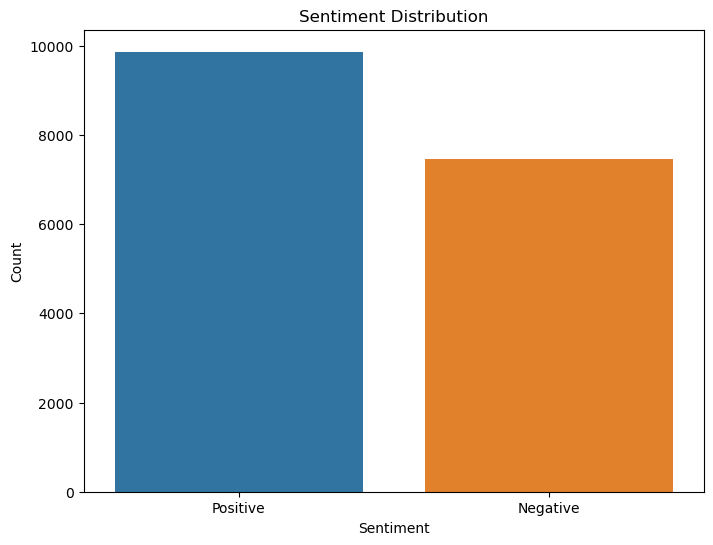

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=train) # histogram to see the count of target value
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


a:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
a:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


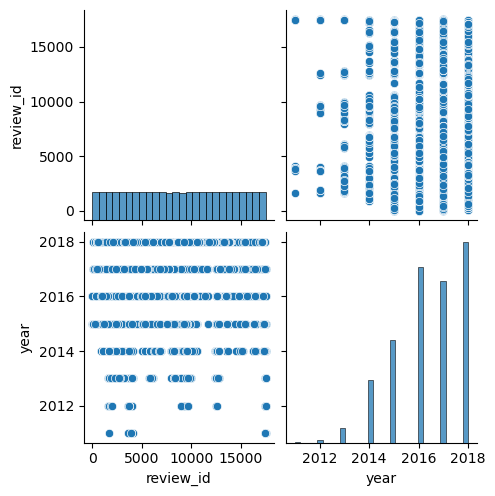

In [168]:
import seaborn as sns
sns.pairplot(train[continuous.columns])

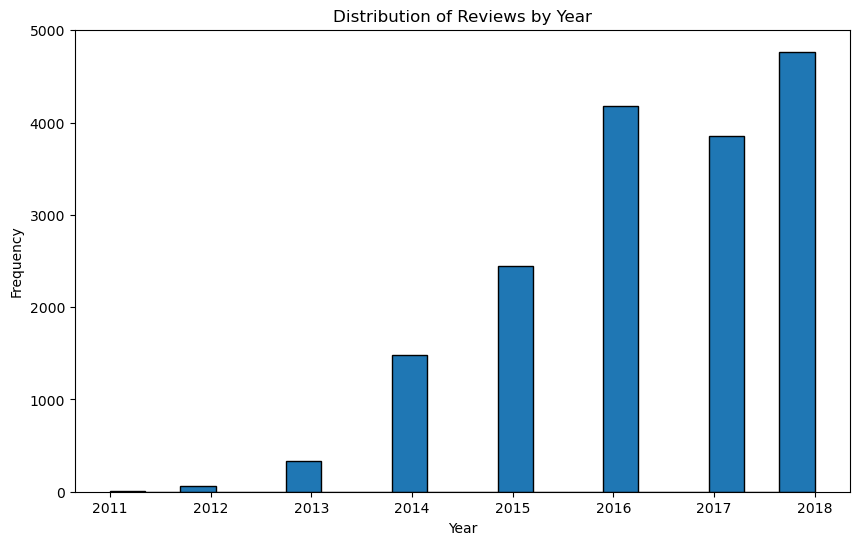

In [169]:
# Histogram for year distribution
plt.figure(figsize=(10, 6))
plt.hist(train['year'].dropna(), bins=20, edgecolor='black')
plt.title('Distribution of Reviews by Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

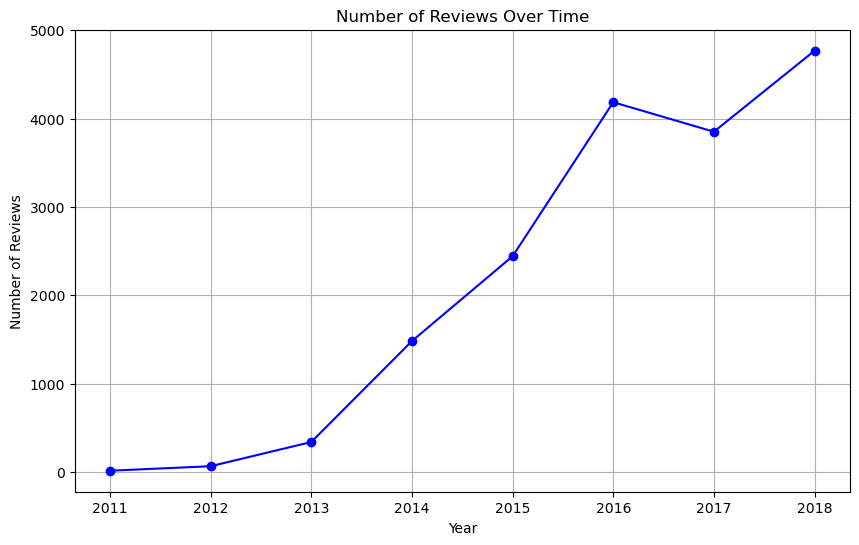

In [170]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the dataset with 'year' column

# Group the data by 'year' and count the number of reviews for each year
reviews_per_year = train.groupby('year').size()

# Plot the line graph
plt.figure(figsize=(10, 6))
reviews_per_year.plot(kind='line', marker='o', color='b', linestyle='-')
plt.title('Number of Reviews Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()


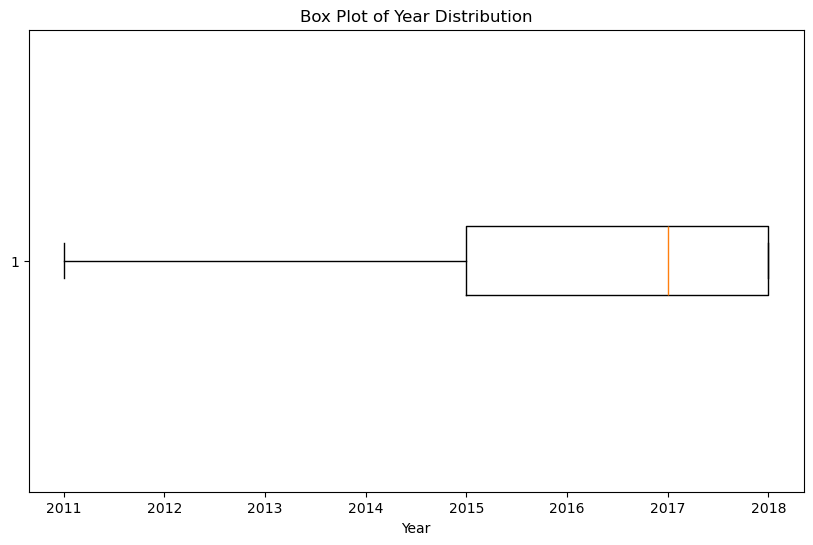

In [171]:
# Box plot for year distribution
plt.figure(figsize=(10, 6))
plt.boxplot(train['year'].dropna(), vert=False)
plt.title('Box Plot of Year Distribution')
plt.xlabel('Year')
plt.show()

## Noticeable traits :
1. The dataset has more number of positive sentiments in the trainning data.
2. From the above line graph we can obser that the number of reviews has seen a significant growth as we proceed in time.

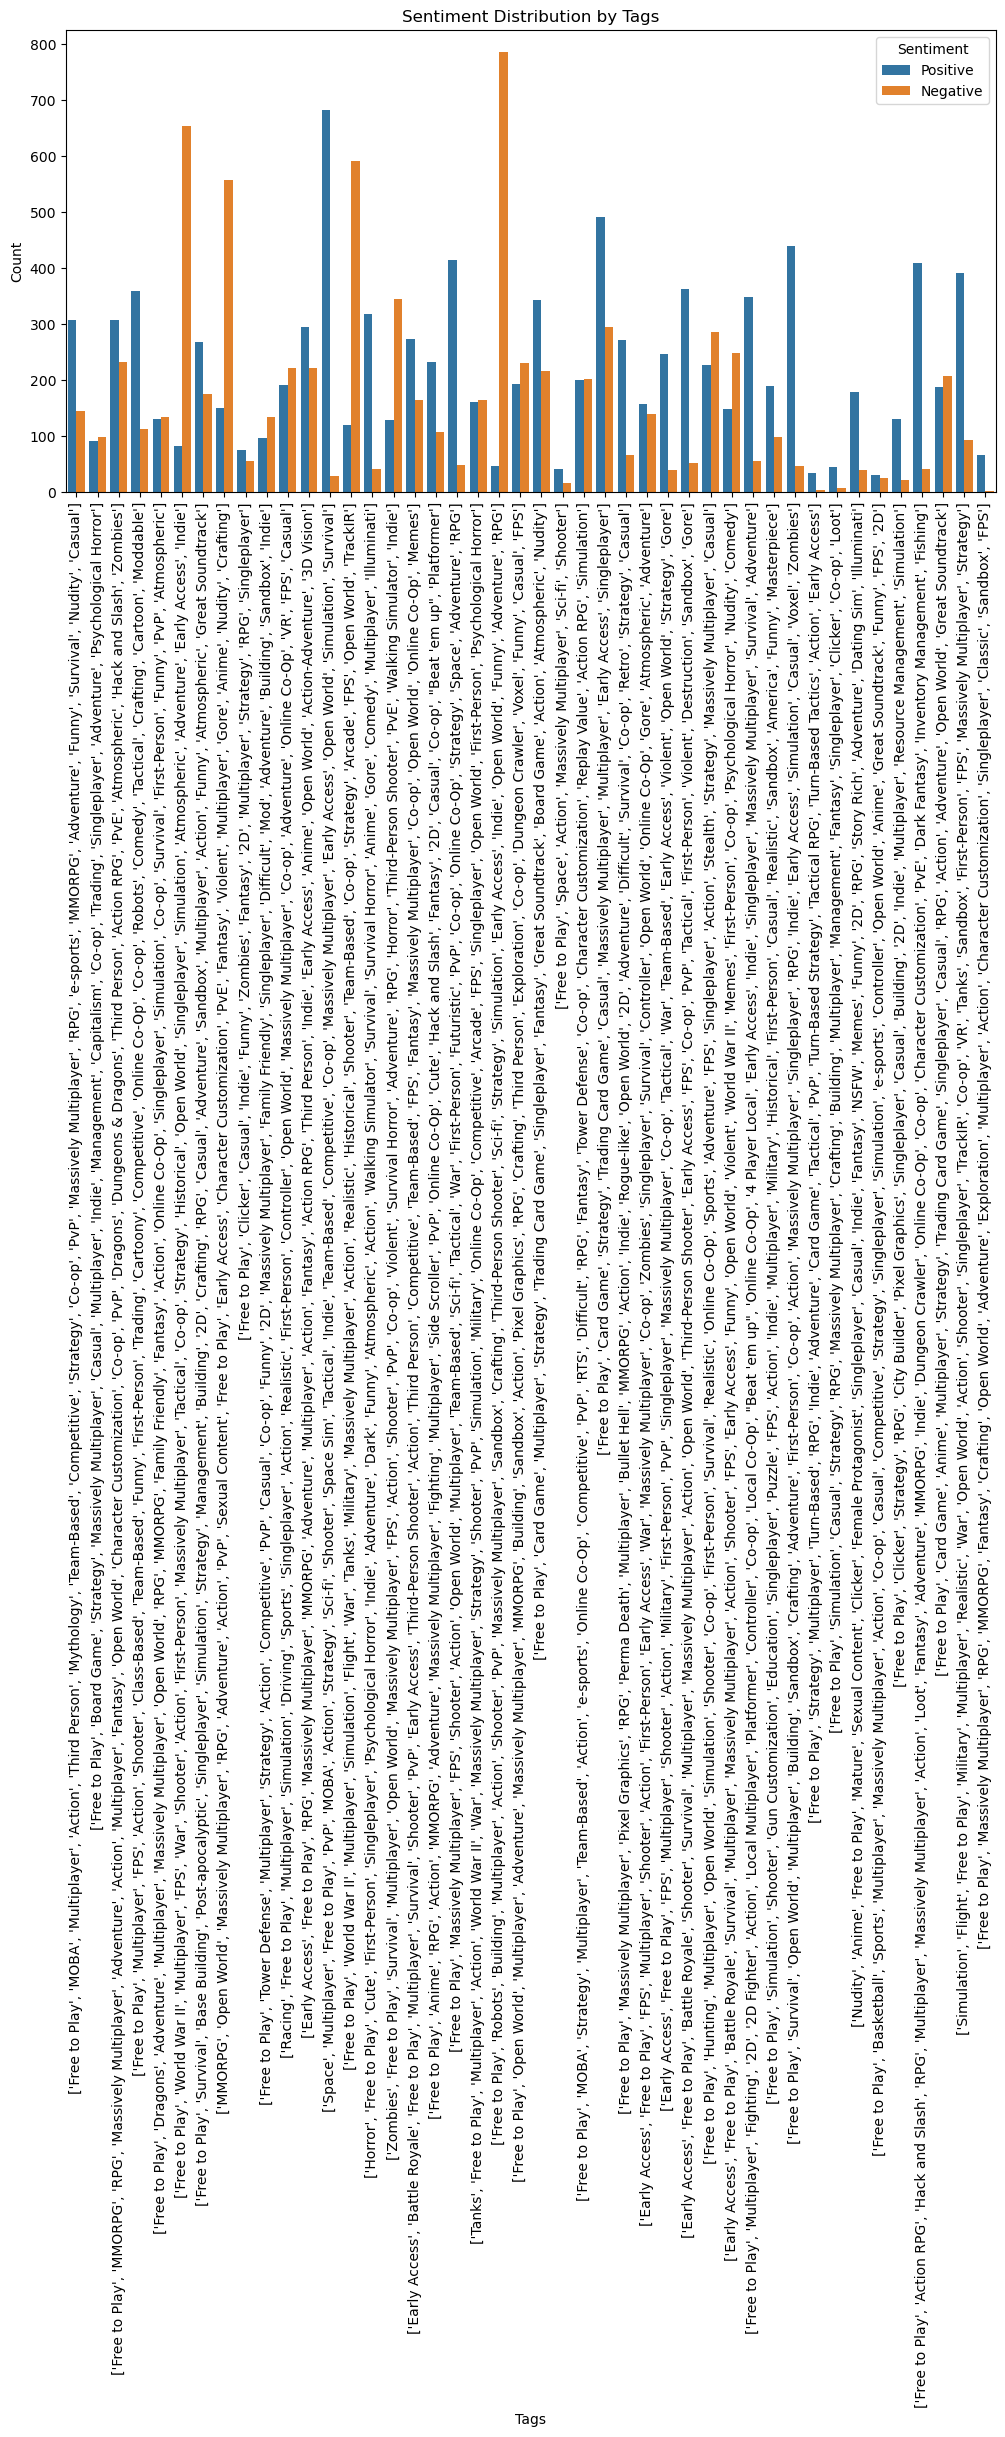

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the dataset with 'tags' and 'sentiment' columns

# Plotting count plot for 'tags' against 'sentiment'
plt.figure(figsize=(12, 6))
sns.countplot(x='tags', hue='sentiment', data=train)
plt.title('Sentiment Distribution by Tags')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Sentiment')
plt.show()


In [173]:
pip install WordCloud

Note: you may need to restart the kernel to use updated packages.


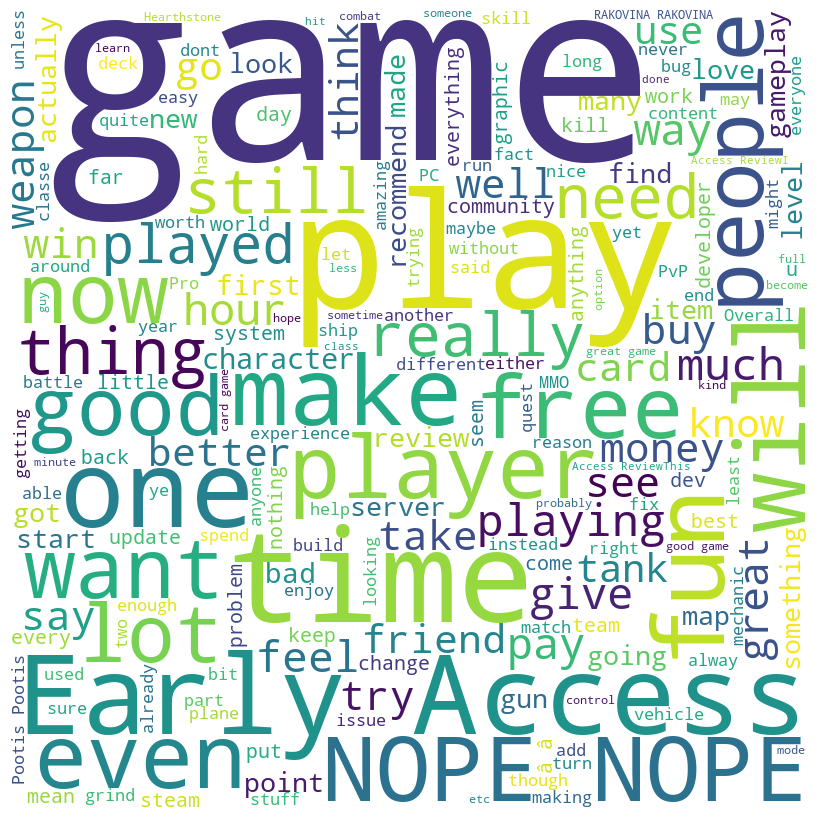

In [174]:
# Import necessary libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate a string of words from the DataFrame column
text = ' '.join(train['user_review'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, 
                      background_color='white',
                      min_font_size=10).generate(text)

# Plot the WordCloud image                        
plt.figure(figsize=(8, 8), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0) 

plt.show()


## Noticeable trends
1. Free-to-play is the most popular tag, followed by "multiplayer" and "shooter". This suggests that gamers are increasingly looking for free, competitive games that they can play with others.
2. Action games are also popular, along with genres like RPG, strategy, and simulation. This suggests that gamers are interested in a variety of genres, but there is a preference for fast-paced and exciting games.
3. There is a growing interest in early access games. 
4. From the word cloud we can easily understand the important words that are used in the game reviews that help to further decide how we can preprocess and clean the data.

In [175]:
train.isna().sum()

review_id        0
title            0
developer        0
publisher        0
tags             0
overview         0
year           178
user_review      0
sentiment        0
dtype: int64

## The attribute has some null valuyes that needs to be handled, we have removed the nulls values as the nulls are less when compared to the shape fo the dataset.

In [176]:
train.dropna(subset=['year'], inplace=True)
train.isna().sum()

review_id      0
title          0
developer      0
publisher      0
tags           0
overview       0
year           0
user_review    0
sentiment      0
dtype: int64

In [177]:
#  unique values for each column in order to decide if any other attributes need special handling.
for column in train.columns:
    unique_values = train[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'review_id': [ 4848 15427  8236 ...  3699  5275 11731]
Unique values in column 'title': ['SMITE®' 'Business Tour - Board Game with Online Multiplayer'
 'Neverwinter' 'Team Fortress 2' 'School of Dragons' 'Heroes & Generals'
 'Fallout Shelter' 'Bless Online' 'Crusaders of the Lost Idols'
 'Bloons TD Battles' 'RaceRoom Racing Experience' 'AdventureQuest 3D'
 'Fractured Space' 'War Thunder' "Spooky's Jump Scare Mansion"
 'Infestation: The New Z' 'Realm Royale' 'Elsword' 'PlanetSide 2'
 'World of Tanks Blitz' 'Robocraft' 'Trove' 'The Elder Scrolls®: Legends™'
 'Dreadnought' 'Dota 2' 'Eternal Card Game' 'Realm of the Mad God'
 'WARMODE' 'Black Squad' 'Ring of Elysium' 'theHunter Classic'
 'Cuisine Royale' 'Brawlhalla' 'World of Guns: Gun Disassembly'
 'Creativerse' 'Tactical Monsters Rumble Arena' 'Shop Heroes'
 'Sakura Clicker' 'Freestyle 2: Street Basketball' 'Realm Grinder'
 'Path of Exile' 'Yu-Gi-Oh! Duel Links' 'DCS World Steam Edition'
 'EverQuest II']
Unique v

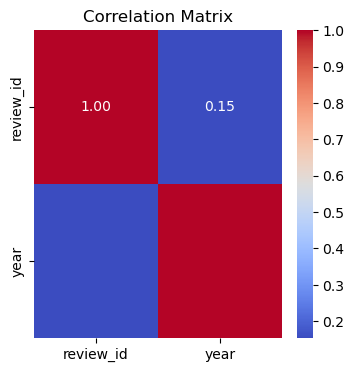

In [178]:
# Correlation matrix
corr_matrix = continuous.corr()
plt.figure(figsize=(4, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### performing label encoding on the target attribute as it is easy for handling numeric data.

In [179]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform 'sentiment' column
train['sentiment'] = label_encoder.fit_transform(train['sentiment'])

# Map labels to their corresponding sentiment values
sentiment_mapping = {0: 'Negative', 1: 'Positive'}

# Print the mapping
print("Label Encoding Mapping:")
for encoded_label, sentiment_label in sentiment_mapping.items():
    print(f"{encoded_label} -> {sentiment_label}")


Label Encoding Mapping:
0 -> Negative
1 -> Positive


### The tags column is a list of words which needs to be handled. 
1. combined the words to form a string
2. Tokenzied the string statement to split them into tokens.
3. Performed the word to vector library fuction to conver the words into vectors.
4. performed the mathematical function of mean value on the list of vectors.
5. this newly computed value, we put in a new column called tag_embeddings

In [180]:
import pandas as pd
from gensim.models import Word2Vec

# Assuming you have already loaded the 'train' dataframe

# Preprocess the tags column to convert each list of tags into a list of words
train['tags'] = train['tags'].apply(lambda x: ' '.join(x))

# Tokenize the tags into individual words
tag_tokens = train['tags'].apply(lambda x: x.split())

# Train Word2Vec model on the tag tokens
word2vec_model = Word2Vec(tag_tokens, vector_size=100, window=5, min_count=1, sg=0)

# Function to get the word vector for a single tag
def get_tag_vector(tag, model):
    try:
        return model.wv[tag]
    except KeyError:
        return None

# Function to get the average vector for a list of tags
def get_average_vector(tags, model):
    tag_vectors = [get_tag_vector(tag, model) for tag in tags]
    tag_vectors = [vec for vec in tag_vectors if vec is not None]  # Filter out None values
    if tag_vectors:
        return sum(tag_vectors) / len(tag_vectors)
    else:
        return None

# Generate word embeddings for each row in the train dataframe
train['tag_embeddings'] = tag_tokens.apply(lambda x: get_average_vector(x, word2vec_model))

# Now train['tag_embeddings'] contains the word embeddings for each row in the dataframe


In [181]:
train['tag_embeddings']

0        [0.15770519, 0.49412814, -0.0067375777, -0.371...
1        [0.16019376, 0.42531377, -0.04181922, -0.35410...
2        [0.19351043, 0.39172307, -0.03426414, -0.32500...
3        [0.21925993, 0.3990609, -0.12578706, -0.355332...
4        [0.23320614, 0.5311879, -0.03737307, -0.350125...
                               ...                        
17314    [0.16088702, 0.45126933, -0.039789148, -0.3341...
17315    [0.16019376, 0.42531377, -0.04181922, -0.35410...
17316    [0.21925993, 0.3990609, -0.12578706, -0.355332...
17317    [0.19834818, 0.54375327, -0.019070819, -0.3516...
17318    [0.16088702, 0.45126933, -0.039789148, -0.3341...
Name: tag_embeddings, Length: 17141, dtype: object

C:\Users\rutur\AppData\Local\Temp\ipykernel_16816\1375033835.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tag Embedding 1'] = df['tag_embeddings'].apply(lambda x: x[0])
C:\Users\rutur\AppData\Local\Temp\ipykernel_16816\1375033835.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tag Embedding 2'] = df['tag_embeddings'].apply(lambda x: x[1])


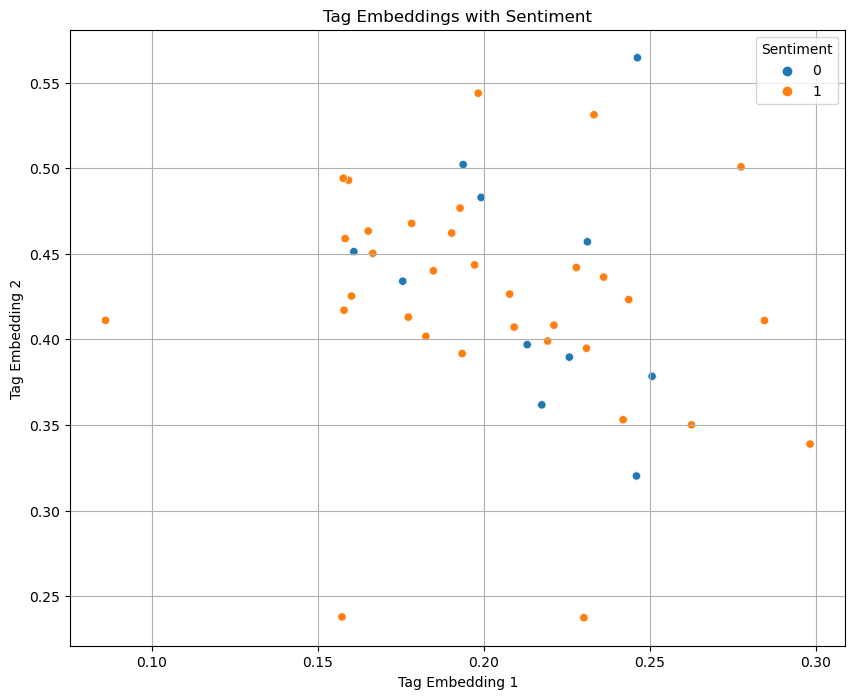

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'train' dataframe with 'tag_embeddings' and 'sentiment' columns

# Create a DataFrame with tag embeddings and sentiments
df = train[['tag_embeddings', 'sentiment']]

# Extract x and y values from tag embeddings
df['Tag Embedding 1'] = df['tag_embeddings'].apply(lambda x: x[0])
df['Tag Embedding 2'] = df['tag_embeddings'].apply(lambda x: x[1])

# Plot scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Tag Embedding 1', y='Tag Embedding 2', hue='sentiment', data=df)
plt.title('Tag Embeddings with Sentiment')
plt.xlabel('Tag Embedding 1')
plt.ylabel('Tag Embedding 2')
plt.legend(title='Sentiment')
plt.grid(True)
plt.show()


In [183]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17141 entries, 0 to 17318
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       17141 non-null  int64  
 1   title           17141 non-null  object 
 2   developer       17141 non-null  object 
 3   publisher       17141 non-null  object 
 4   tags            17141 non-null  object 
 5   overview        17141 non-null  object 
 6   year            17141 non-null  float64
 7   user_review     17141 non-null  object 
 8   sentiment       17141 non-null  int32  
 9   tag_embeddings  17141 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(7)
memory usage: 1.4+ MB


### The columns title,developer and publisher are small text columns and are named based text which we have handled using the label encoder to map them to numeric values.

In [184]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform 'title', 'developer', and 'publisher' columns
train['title'] = label_encoder.fit_transform(train['title'])
train['developer'] = label_encoder.fit_transform(train['developer'])
train['publisher'] = label_encoder.fit_transform(train['publisher'])


In [185]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17141 entries, 0 to 17318
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       17141 non-null  int64  
 1   title           17141 non-null  int32  
 2   developer       17141 non-null  int32  
 3   publisher       17141 non-null  int32  
 4   tags            17141 non-null  object 
 5   overview        17141 non-null  object 
 6   year            17141 non-null  float64
 7   user_review     17141 non-null  object 
 8   sentiment       17141 non-null  int32  
 9   tag_embeddings  17141 non-null  object 
dtypes: float64(1), int32(4), int64(1), object(4)
memory usage: 1.2+ MB


### the tag_embeddings is a list of vectors. Dealing with lists is complex operation, thus we performed the sum of the elements of the list and represented single value for tags columns.

In [186]:
# 'tag_embeddings' contains lists of numbers
train['sum_tag_embeddings'] = train['tag_embeddings'].apply(lambda x: sum(x))

In [187]:
train.head(10)

,review_id,title,developer,publisher,tags,overview,year,user_review,sentiment,tag_embeddings,sum_tag_embeddings
0,4848,29,35,17,"[ ' F r e e t o P l a y ' , ' M O B A ' ...",Enter the Battleground of the GodsJoin the mil...,2016.0,"I've played this game since before beta ended,...",1,"[0.15770519, 0.49412814, -0.0067375777, -0.371...",-1.071580
1,15427,5,7,0,"[ ' F r e e t o P l a y ' , ' B o a r d ...","""Business Tour"" simple and entertaining gamepl...",2018.0,"fun little game , but you really need to put a...",1,"[0.16019376, 0.42531377, -0.04181922, -0.35410...",0.285690
2,8236,20,8,28,"[ ' F r e e t o P l a y ' , ' M M O R P ...",,2014.0,First of all this is not a pay to win game. ZE...,1,"[0.19351043, 0.39172307, -0.03426414, -0.32500...",-1.291078
3,3805,35,37,36,"[ ' F r e e t o P l a y ' , ' M u l t i ...","""The most fun you can have online"" - PC GamerI...",2014.0,this game have all very funny and tactical...,1,"[0.21925993, 0.3990609, -0.12578706, -0.355332...",-0.986237
4,17261,31,22,19,"[ ' F r e e t o P l a y ' , ' D r a g o ...",**Changewing Dragon now Available**Fly Fast. T...,2017.0,"This is a great game, it really is. I understa...",1,"[0.23320614, 0.5311879, -0.03737307, -0.350125...",-0.324365
5,6648,18,31,30,"[ ' F r e e t o P l a y ' , ' W o r l d ...","Heroes & Generals is a full on, all-out WAR ex...",2018.0,Optimise this game! Before the vehicle psyhic ...,0,"[0.2507221, 0.37843516, -0.039366797, -0.31876...",-0.021735
6,12961,15,2,2,"[ ' F r e e t o P l a y ' , ' S u r v i ...",Fallout Shelter puts you in control of a state...,2018.0,Product received for freeNice Fallout Shelter ...,1,"[0.26257786, 0.35009265, -0.04672729, -0.33255...",-0.029168
7,11983,2,26,24,"[ ' M M O R P G ' , ' O p e n W o r l d ' ...",“We invite you all to the world of Bless Onlin...,2018.0,Early Access ReviewDo not purchase this game u...,0,"[0.16088702, 0.45126933, -0.039789148, -0.3341...",-1.018123
8,15484,7,6,5,"[ ' F r e e t o P l a y ' , ' C l i c k ...","Unlock crusaders, Collect gear, and Earn achie...",2017.0,Worst game ever played !!!! Please do not wast...,0,"[0.21309875, 0.39695734, -0.050133687, -0.2852...",0.300099
9,16590,3,28,26,"[ ' F r e e t o P l a y ' , ' T o w e r ...",Play the top-rated tower defense franchise in ...,2017.0,Product received for freeLooking for a game to...,1,"[0.19922824, 0.48291758, -0.0721835, -0.370037...",0.371138


### Feature Engineering: Since the long textual data columns user_review and overiew are providing the brief details of the game, we have planned to combine it and make a single large text data which will be further processessed. This reduces the memory read and write operations as we will be elimiating the 2 columns and mergin into one.

In [188]:
# Combine 'user_review' and 'overview' into a single column
train['combined_text'] = train['user_review'] + ' ' + train['overview']
train['combined_text']

0        I've played this game since before beta ended,...
1        fun little game , but you really need to put a...
2        First of all this is not a pay to win game. ZE...
3        this game  have all   very funny  and tactical...
4        This is a great game, it really is. I understa...
                               ...                        
17314    Played for roughly 2 hours.  The best part of ...
17315    Note:Make sure you have friends. That's all.My...
17316    Special, funny, lucky, friendly, exciting, hea...
17317    Product received for freeThis is a free, frien...
17318    Ok, I've seen enough. Let me start from the be...
Name: combined_text, Length: 17141, dtype: object

### Now we are perfomring the preprocessing of the data. 
#### We are follwoing the sequence of steps: 
1. Tokenize the text
2. Lemmatize the text
3. Remove stop words

### The reason why we are perfomring lemmatization is because we want to maintain the origincal meaing of the text and we kno that lemmatization maintain the originality of the words as it maps to the dictonary meanings.

In [189]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
def tokenize_lemmatize_remove_stopwords(text):
    # Limit the length of the string to 200 characters
    text = text[:200]

    # Tokenize the text using NLTK
    tokens = word_tokenize(text)

    # Lemmatize the tokens using NLTK
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in lemmatized_tokens if token.lower() not in stop_words]

    return filtered_tokens

# Apply tokenization, lemmatization, and stopword removal to the 'overview' column
train['combined_text_tokens_lemmatized_stopwords_removed'] = train['combined_text'].apply(tokenize_lemmatize_remove_stopwords)



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rutur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rutur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rutur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [190]:
train['combined_text_tokens_lemmatized_stopwords_removed']

0        ['ve, played, game, since, beta, ended, ,, 'm,...
1        [fun, little, game, ,, really, need, put, vote...
2        [First, pay, win, game, ., ZEN, currency, buy,...
3        [game, funny, tactical, want, ,, playing, like...
4        [great, game, ,, really, ., understand, member...
                               ...                        
17314    [Played, roughly, 2, hour, ., best, part, game...
17315    [Note, :, Make, sure, friend, ., 's, all.My, b...
17316    [Special, ,, funny, ,, lucky, ,, friendly, ,, ...
17317    [Product, received, freeThis, free, ,, friendl...
17318    [Ok, ,, 've, seen, enough, ., Let, start, begi...
Name: combined_text_tokens_lemmatized_stopwords_removed, Length: 17141, dtype: object

### Next we are applying mathematical operations such as averages and summation of vectors of the combined a dn cleaned text to use it further for fitting models.

In [191]:
import pandas as pd
from gensim.models import Word2Vec

# Train Word2Vec model on the lemmatized and stopwords-removed tokens
word2vec_model_overview = Word2Vec(train['combined_text_tokens_lemmatized_stopwords_removed'], vector_size=100, window=5, min_count=1, sg=0)

# Function to get the word vector for a single token
def get_word_vector(token, model):
    try:
        return model.wv[token]
    except KeyError:
        return None

# Function to get the average vector for a list of tokens
def get_average_vector_tokens(tokens, model):
    token_vectors = [get_word_vector(token, model) for token in tokens]
    token_vectors = [vec for vec in token_vectors if vec is not None]  # Filter out None values
    if token_vectors:
        return sum(token_vectors) / len(token_vectors)
    else:
        return None

# Generate word embeddings for each row in the train dataframe and store them in a new column
train['combined_text_tokens_lemmatized_stopwords_removed'] = train['combined_text_tokens_lemmatized_stopwords_removed'].apply(lambda x: get_average_vector_tokens(x, word2vec_model_overview))


In [192]:
train['combined_text_tokens_lemmatized_stopwords_removed']

0        [-0.13891338, 0.5385526, -0.021532705, 0.55490...
1        [-0.14364503, 0.4553084, 0.16934796, 0.5272342...
2        [-0.21364793, 0.20932256, 0.116300665, 0.44550...
3        [-0.24009053, 0.4830392, 0.20905685, 0.7101192...
4        [-0.16415432, 0.6943885, 0.16963436, 0.6122994...
                               ...                        
17314    [-0.080561146, 0.62395954, 0.15466817, 0.57005...
17315    [-0.15481037, 0.3967864, 0.06736788, 0.3445350...
17316    [-0.15707363, 0.55980366, 0.22554815, 0.408836...
17317    [-0.32771596, 0.7245429, 0.2336285, 0.45617774...
17318    [-0.13952169, 0.6439227, 0.13278458, 0.5538882...
Name: combined_text_tokens_lemmatized_stopwords_removed, Length: 17141, dtype: object

### As mentioned before it is difficult to handle the list of values and takes up too much memory, so we are reducing it to single values by summing the list of vectors.

In [193]:
import numpy as np

# Calculate the sum of each list in the 'overview_tokens_lemmatized_stopwords_removed' column
train['combined_text_tokens_lemmatized_stopwords_removed'] = train['combined_text_tokens_lemmatized_stopwords_removed'].apply(lambda x: np.sum(x) if isinstance(x, np.ndarray) else None)


In [194]:
train.head(5)

,review_id,title,developer,publisher,tags,overview,year,user_review,sentiment,tag_embeddings,sum_tag_embeddings,combined_text,combined_text_tokens_lemmatized_stopwords_removed
0,4848,29,35,17,"[ ' F r e e t o P l a y ' , ' M O B A ' ...",Enter the Battleground of the GodsJoin the mil...,2016.0,"I've played this game since before beta ended,...",1,"[0.15770519, 0.49412814, -0.0067375777, -0.371...",-1.071580,"I've played this game since before beta ended,...",3.553743
1,15427,5,7,0,"[ ' F r e e t o P l a y ' , ' B o a r d ...","""Business Tour"" simple and entertaining gamepl...",2018.0,"fun little game , but you really need to put a...",1,"[0.16019376, 0.42531377, -0.04181922, -0.35410...",0.285690,"fun little game , but you really need to put a...",1.549000
2,8236,20,8,28,"[ ' F r e e t o P l a y ' , ' M M O R P ...",,2014.0,First of all this is not a pay to win game. ZE...,1,"[0.19351043, 0.39172307, -0.03426414, -0.32500...",-1.291078,First of all this is not a pay to win game. ZE...,-1.951734
3,3805,35,37,36,"[ ' F r e e t o P l a y ' , ' M u l t i ...","""The most fun you can have online"" - PC GamerI...",2014.0,this game have all very funny and tactical...,1,"[0.21925993, 0.3990609, -0.12578706, -0.355332...",-0.986237,this game have all very funny and tactical...,1.832390
4,17261,31,22,19,"[ ' F r e e t o P l a y ' , ' D r a g o ...",**Changewing Dragon now Available**Fly Fast. T...,2017.0,"This is a great game, it really is. I understa...",1,"[0.23320614, 0.5311879, -0.03737307, -0.350125...",-0.324365,"This is a great game, it really is. I understa...",2.030817


In [195]:
train.columns # checking the columns in order to drop the old columns which we have preprocessed and updated into other columns

Index(['review_id', 'title', 'developer', 'publisher', 'tags', 'overview',
       'year', 'user_review', 'sentiment', 'tag_embeddings',
       'sum_tag_embeddings', 'combined_text',
       'combined_text_tokens_lemmatized_stopwords_removed'],
      dtype='object')

### dropping the unwanted columns as they are no longer needed.

In [196]:
train.drop(['tags', 'user_review','overview','tag_embeddings'], axis=1, inplace=True)

In [197]:
train.columns

Index(['review_id', 'title', 'developer', 'publisher', 'year', 'sentiment',
       'sum_tag_embeddings', 'combined_text',
       'combined_text_tokens_lemmatized_stopwords_removed'],
      dtype='object')

In [198]:
train.drop(['combined_text'], axis=1, inplace=True)

In [199]:
train.isna().sum()

review_id                                            0
title                                                0
developer                                            0
publisher                                            0
year                                                 0
sentiment                                            0
sum_tag_embeddings                                   0
combined_text_tokens_lemmatized_stopwords_removed    1
dtype: int64

In [200]:
train.head()

,review_id,title,developer,publisher,year,sentiment,sum_tag_embeddings,combined_text_tokens_lemmatized_stopwords_removed
0,4848,29,35,17,2016.0,1,-1.071580,3.553743
1,15427,5,7,0,2018.0,1,0.285690,1.549000
2,8236,20,8,28,2014.0,1,-1.291078,-1.951734
3,3805,35,37,36,2014.0,1,-0.986237,1.832390
4,17261,31,22,19,2017.0,1,-0.324365,2.030817


In [201]:
train.dropna(subset=['combined_text_tokens_lemmatized_stopwords_removed'], inplace=True)

In [202]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
X = train.drop(columns=['sentiment'])  # Features
y = train['sentiment']  # Target variable
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = LogisticRegression()
# Fit the model and predict 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
classification_reports = classification_report(y_test, y_pred) # using the classification report
print("Classification Report:")
print(classification_reports)


Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.39      0.45      1438
           1       0.63      0.75      0.69      1990

    accuracy                           0.60      3428
   macro avg       0.58      0.57      0.57      3428
weighted avg       0.59      0.60      0.59      3428



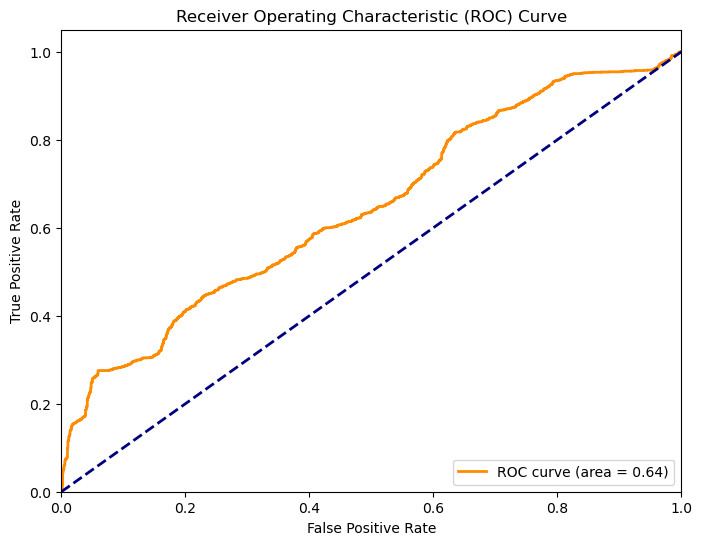

In [203]:
from sklearn.metrics import roc_curve, auc # roc-auc curve
import matplotlib.pyplot as plt
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [204]:
print(X_train.columns)

Index(['review_id', 'title', 'developer', 'publisher', 'year',
       'sum_tag_embeddings',
       'combined_text_tokens_lemmatized_stopwords_removed'],
      dtype='object')


In [205]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import xgboost as xgb

# Split the data into features and target variable
X = train.drop(columns=['sentiment'])  # Features
y = train['sentiment']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train the AdaBoost classifier
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.predict(X_test)
print("Classification Report for AdaBoost:")
print(classification_report(y_test, y_pred_ada))

# Instantiate and train the GradientBoosting classifier
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
print("Classification Report for GradientBoosting:")
print(classification_report(y_test, y_pred_gb))

# Instantiate and train the XGBoost classifier
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))


Classification Report for AdaBoost:
              precision    recall  f1-score   support

           0       0.69      0.62      0.65      1438
           1       0.74      0.80      0.77      1990

    accuracy                           0.72      3428
   macro avg       0.72      0.71      0.71      3428
weighted avg       0.72      0.72      0.72      3428

Classification Report for GradientBoosting:
              precision    recall  f1-score   support

           0       0.76      0.65      0.70      1438
           1       0.77      0.86      0.81      1990

    accuracy                           0.77      3428
   macro avg       0.77      0.75      0.76      3428
weighted avg       0.77      0.77      0.77      3428

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.74      0.71      0.72      1438
           1       0.79      0.82      0.81      1990

    accuracy                           0.77      3428
   macro avg 

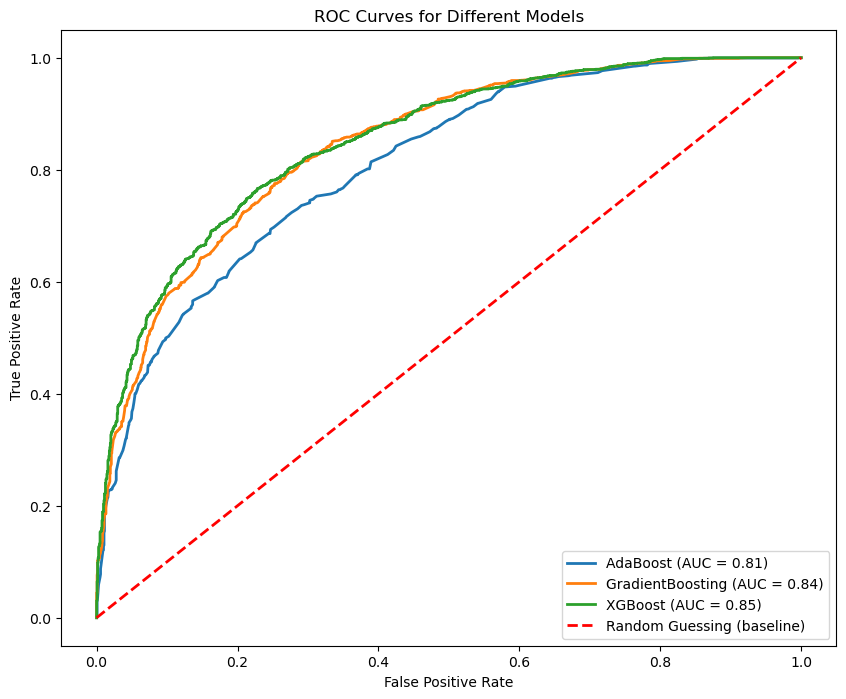

In [206]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(model, X_test, y_test, model_name):
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_prob = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='%s (AUC = %0.2f)' % (model_name, roc_auc))

plt.figure(figsize=(10, 8))
# AdaBoost
plot_roc_curve(ada_model, X_test, y_test, "AdaBoost")
# Gradient Boosting
plot_roc_curve(gb_model, X_test, y_test, "GradientBoosting")
# XGBoost
plot_roc_curve(xgb_model, X_test, y_test, "XGBoost")
# Random guessing (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guessing (baseline)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc="lower right")
plt.show()


In [207]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

# Split the data into features (X) and target variable (y)
X = train.drop(columns=['sentiment'])  # Features
y = train['sentiment']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train the AdaBoost classifier
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.predict(X_test)
ada_roc_auc = roc_auc_score(y_test, y_pred_ada)
ada_classification_report = classification_report(y_test, y_pred_ada)

# Instantiate and train the XGBoost classifier
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_roc_auc = roc_auc_score(y_test, y_pred_xgb)
xgb_classification_report = classification_report(y_test, y_pred_xgb)

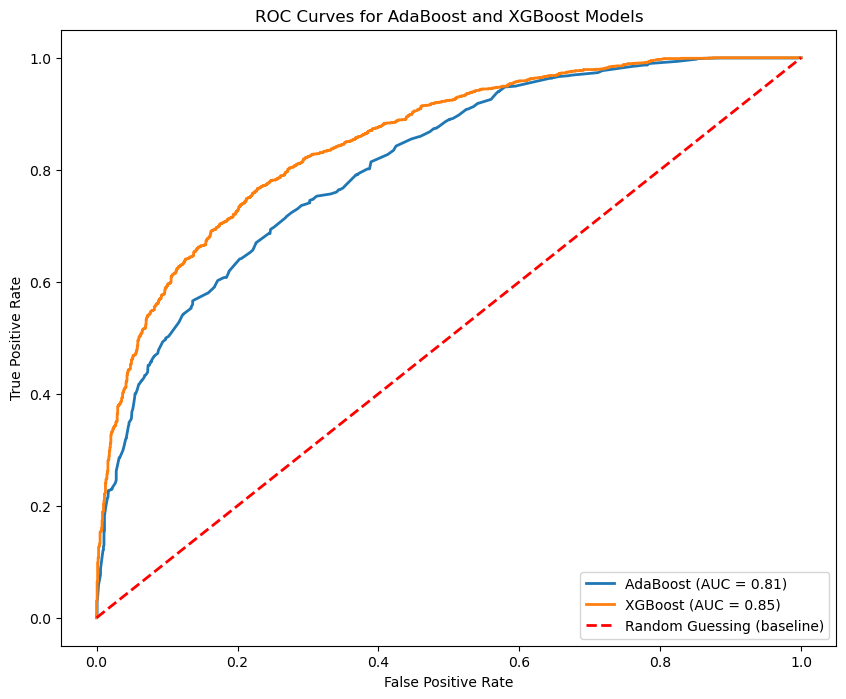

In [208]:
# Plot ROC AUC curves for AdaBoost and XGBoost
plt.figure(figsize=(10, 8))
# AdaBoost
plot_roc_curve(ada_model, X_test, y_test, "AdaBoost")
# XGBoost
plot_roc_curve(xgb_model, X_test, y_test, "XGBoost")
# Random guessing (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guessing (baseline)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for AdaBoost and XGBoost Models')
plt.legend(loc="lower right")
plt.show()

In [209]:
print(X_train)

       review_id  title  developer  publisher    year  sum_tag_embeddings  \
9427        2752     39         18         14  2016.0            0.153858   
8540        4820     29         35         17  2017.0           -1.071580   
11983      10706     13         11          8  2018.0            0.485230   
9641        2630     39         18         14  2018.0            0.153858   
2366       12663     23         32         31  2014.0           -0.671316   
...          ...    ...        ...        ...     ...                 ...   
11408       1388     16         14          9  2016.0           -0.255674   
12093       8001     20          8         28  2017.0           -1.291078   
5456       14226     19         16         11  2016.0           -1.004688   
867        16057      0          0          1  2016.0           -0.694591   
15958      14137     19         16         11  2017.0           -1.004688   

       combined_text_tokens_lemmatized_stopwords_removed  
9427            

In [210]:
# the best model based on the best ROC AUC score
best_model = ada_model if ada_roc_auc > xgb_roc_auc else xgb_model
best_classification_report = ada_classification_report if ada_roc_auc > xgb_roc_auc else xgb_classification_report
print("Best Model's Classification Report:")
print(best_classification_report)


Best Model's Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.72      1438
           1       0.79      0.82      0.81      1990

    accuracy                           0.77      3428
   macro avg       0.77      0.76      0.76      3428
weighted avg       0.77      0.77      0.77      3428



In [211]:
X

,review_id,title,developer,publisher,year,sum_tag_embeddings,combined_text_tokens_lemmatized_stopwords_removed
0,4848,29,35,17,2016.0,-1.071580,3.553743
1,15427,5,7,0,2018.0,0.285690,1.549000
2,8236,20,8,28,2014.0,-1.291078,-1.951734
3,3805,35,37,36,2014.0,-0.986237,1.832390
4,17261,31,22,19,2017.0,-0.324365,2.030817
...,...,...,...,...,...,...,...
17314,12056,2,26,24,2018.0,-1.018123,0.789610
17315,15441,5,7,0,2017.0,0.285690,0.335095
17316,3699,35,37,36,2016.0,-0.986237,0.516067
17317,5275,4,3,35,2018.0,-0.566711,1.264354


In [212]:
best_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [213]:
# Load the dataset
test = pd.read_csv('../test.csv')
test.head(5)

,review_id,title,developer,publisher,tags,overview,year,user_review
0,9691,Realm of the Mad God,"Wild Shadow Studios, Deca Games",Deca Games,"['Free to Play', 'Massively Multiplayer', 'Pix...",Realm of the Mad God is the first ever free to...,2017.0,ROTMG is a free bullet hell-style mmorp...
1,4014,Team Fortress 2,Valve,Valve,"['Free to Play', 'Multiplayer', 'FPS', 'Action...","""The most fun you can have online"" - PC GamerI...",2011.0,"Team Fortress 2, seems like such an understate..."
2,1910,Dota 2,Valve,Valve,"['Free to Play', 'MOBA', 'Strategy', 'Multipla...","The most-played game on Steam.Every day, milli...",2014.0,"Very good tool to learn new words, such as♥♥♥♥..."
3,7378,The Elder Scrolls®: Legends™,"Sparkypants Studios, LLC",Bethesda Softworks,"['Free to Play', 'Card Game', 'Multiplayer', '...",PLAY ON YOUR OWNStory mode provides hours of s...,2017.0,While the presentation of this game is phenome...
4,7488,Trove,Trion Worlds,Trion Worlds,"['Free to Play', 'Open World', 'Multiplayer', ...","Grab your friends, hone your blades, and set o...",2017.0,"Glad to have wasted 1k hours on this game, end..."


In [214]:
test.dropna(subset=['year'], inplace=True)
test.isna().sum()

review_id      0
title          0
developer      0
publisher      0
tags           0
overview       0
year           0
user_review    0
dtype: int64

In [215]:
# Preprocess the tags column in the test data to convert each list of tags into a list of words
test['tags'] = test['tags'].apply(lambda x: ' '.join(x))
tag_tokens_test = test['tags'].apply(lambda x: x.split())
# this Function to generate word embeddings for each row in the test dataframe
def generate_embeddings(row, model):
    tag_vectors = [get_tag_vector(tag, model) for tag in row]
    tag_vectors = [vec for vec in tag_vectors if vec is not None]  # Filter out None values
    if tag_vectors:
        return sum(tag_vectors) / len(tag_vectors)
    else:
        return None
# Generate word embeddings for each row in the test dataframe
test['tag_embeddings'] = tag_tokens_test.apply(lambda x: generate_embeddings(x, word2vec_model))


In [216]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# we will Fit and transform 'title', 'developer', and 'publisher' columns
test['title'] = label_encoder.fit_transform(test['title'])
test['developer'] = label_encoder.fit_transform(test['developer'])
test['publisher'] = label_encoder.fit_transform(test['publisher'])


In [217]:
test['sum_tag_embeddings'] = test['tag_embeddings'].apply(lambda x: sum(x))

In [218]:
test['combined_text'] = test['user_review'] + ' ' + test['overview']
test['combined_text']

0             ROTMG is a free bullet hell-style mmorp...
1      Team Fortress 2, seems like such an understate...
2      Very good tool to learn new words, such as♥♥♥♥...
3      While the presentation of this game is phenome...
4      Glad to have wasted 1k hours on this game, end...
                             ...                        
170    Quite a spectacular game all around! I come fr...
171    A really great game! I would love to donate to...
172    World of guns, what can I say.I'm not a huge f...
173    Early Access ReviewHands down one of the best ...
174    DCS World is a free to play extremely realisti...
Name: combined_text, Length: 175, dtype: object

In [219]:
# Importing necessary libraries
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
def tokenize_lemmatize_remove_stopwords(text):
    # Limit the length of the string to 200 characters
    text = text[:200]
    # Tokenize the text using NLTK
    tokens = word_tokenize(text)
    # Lemmatize the tokens using NLTK
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in lemmatized_tokens if token.lower() not in stop_words]
    return filtered_tokens

test['combined_text_tokens_lemmatized_stopwords_removed'] = test['combined_text'].apply(tokenize_lemmatize_remove_stopwords)


In [220]:
# we are generating word embeddings for each row in the test dataframe and store them in a new column
test['combined_text_tokens_lemmatized_stopwords_removed'] = test['combined_text_tokens_lemmatized_stopwords_removed'].apply(lambda x: get_average_vector_tokens(x, word2vec_model_overview))


In [221]:
test.head(10)

,review_id,title,developer,publisher,tags,overview,year,user_review,tag_embeddings,sum_tag_embeddings,combined_text,combined_text_tokens_lemmatized_stopwords_removed
0,9691,24,37,4,"[ ' F r e e t o P l a y ' , ' M a s s i ...",Realm of the Mad God is the first ever free to...,2017.0,ROTMG is a free bullet hell-style mmorp...,"[0.17830278, 0.46774906, -0.045416977, -0.3525...",-0.322241,ROTMG is a free bullet hell-style mmorp...,"[-0.09441304, 0.52975667, 0.17117848, 0.478621..."
1,4014,31,34,33,"[ ' F r e e t o P l a y ' , ' M u l t i ...","""The most fun you can have online"" - PC GamerI...",2011.0,"Team Fortress 2, seems like such an understate...","[0.21925993, 0.3990609, -0.12578706, -0.355332...",-0.986237,"Team Fortress 2, seems like such an understate...","[-0.18123749, 0.45614123, 0.081465885, 0.60618..."
2,1910,9,34,33,"[ ' F r e e t o P l a y ' , ' M O B A ' ...","The most-played game on Steam.Every day, milli...",2014.0,"Very good tool to learn new words, such as♥♥♥♥...","[0.23097071, 0.39481276, -0.062289596, -0.3820...",-1.083009,"Very good tool to learn new words, such as♥♥♥♥...","[-0.2808497, 0.4497475, 0.1507154, 0.63377786,..."
3,7378,32,31,1,"[ ' F r e e t o P l a y ' , ' C a r d ...",PLAY ON YOUR OWNStory mode provides hours of s...,2017.0,While the presentation of this game is phenome...,"[0.23016955, 0.23745243, -0.039774057, -0.3399...",1.087202,While the presentation of this game is phenome...,"[-0.086238295, 0.58444446, 0.2201214, 0.558910..."
4,7488,33,33,31,"[ ' F r e e t o P l a y ' , ' O p e n ...","Grab your friends, hone your blades, and set o...",2017.0,"Glad to have wasted 1k hours on this game, end...","[0.19380525, 0.5021262, -0.074414186, -0.25926...",-0.383600,"Glad to have wasted 1k hours on this game, end...","[-0.22369006, 0.3676513, 0.2088241, 0.6404069,..."
5,10391,39,12,7,"[ ' F r e e t o P l a y ' , ' H u n t i ...",The most realistic online hunting game ever cr...,2017.0,I recommend the game but........ THE MISSING T...,"[0.27750313, 0.5007751, -0.034180053, -0.33610...",-0.635291,I recommend the game but........ THE MISSING T...,"[-0.106201865, 0.34580025, 0.07326812, 0.32627..."
6,14434,26,14,9,"[ ' F r e e t o P l a y ' , ' R o b o t ...","Build insane, fully customisable robot battle ...",2016.0,Early Access ReviewRuined the game with the ne...,"[0.22579636, 0.38963586, -0.053809322, -0.3428...",-0.759712,Early Access ReviewRuined the game with the ne...,"[-0.29713345, 0.4853858, 0.13459404, 0.4835332..."
7,12781,21,29,28,"[ ' R a c i n g ' , ' F r e e t o P l a ...",RaceRoom is the premier free-to-play racing si...,2014.0,Pros:-great sounds-great simulation feeling-co...,"[0.24628557, 0.56449115, -0.081179716, -0.3216...",-0.671316,Pros:-great sounds-great simulation feeling-co...,"[-0.45032623, 0.3742416, 0.12351922, 0.5200153..."
8,2780,35,15,11,"[ ' F r e e t o P l a y ' , ' W o r l d ...",War Thunder is the most comprehensive free-to-...,2018.0,Gameplay is some of the best when it comes to ...,"[0.21749817, 0.3617615, -0.035981726, -0.29373...",0.153858,Gameplay is some of the best when it comes to ...,"[-0.053686738, 0.4341515, 0.061896544, 0.63559..."
9,10770,12,8,5,"[ ' F r e e t o P l a y ' , ' C a r d ...",The Game Has ChangedSix-guns and sorcery colli...,2017.0,Early Access ReviewBest digital TCG available ...,"[0.08609633, 0.41114873, 0.013940996, -0.31505...",0.485230,Early Access ReviewBest digital TCG available ...,"[-0.22892725, 0.8056509, 0.11992557, 0.4389475..."


In [222]:
import numpy as np
# we are Calculating the sum of each list in the 'overview_tokens_lemmatized_stopwords_removed' column
test['combined_text_tokens_lemmatized_stopwords_removed'] = test['combined_text_tokens_lemmatized_stopwords_removed'].apply(lambda x: np.sum(x) if isinstance(x, np.ndarray) else None)


In [223]:
test.drop(['tags', 'user_review', 'overview', 'tag_embeddings','combined_text'], axis=1, inplace=True)


### Let's gather the accuracy scores for each model: 
1. Logistic Regression: Accuracy = 0.60
2. AdaBoost: Accuracy = 0.73
3. Gradient Boosting: Accuracy = 0.77
4. XGBoost: Accuracy = 0.77
### Based on the accuracy scores alone, both Gradient Boosting model has the highest accuracy of 0.77. Therefore, we use gradient boosting as the best model based on accuracy.

In [224]:
test.columns

Index(['review_id', 'title', 'developer', 'publisher', 'year',
       'sum_tag_embeddings',
       'combined_text_tokens_lemmatized_stopwords_removed'],
      dtype='object')

In [225]:
train.columns

Index(['review_id', 'title', 'developer', 'publisher', 'year', 'sentiment',
       'sum_tag_embeddings',
       'combined_text_tokens_lemmatized_stopwords_removed'],
      dtype='object')

In [226]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 7 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   review_id                                          175 non-null    int64  
 1   title                                              175 non-null    int32  
 2   developer                                          175 non-null    int32  
 3   publisher                                          175 non-null    int32  
 4   year                                               175 non-null    float64
 5   sum_tag_embeddings                                 175 non-null    float64
 6   combined_text_tokens_lemmatized_stopwords_removed  175 non-null    float32
dtypes: float32(1), float64(2), int32(3), int64(1)
memory usage: 7.0 KB


In [227]:
your_best_model = best_model 
result =list()
pred_probabilities = your_best_model.predict_proba(test)[:,1]
print(pred_probabilities)
pred_probabilities = pd.DataFrame(pred_probabilities, columns=['PositiveSentimentProbability'])
pred_probabilities.to_csv('./submission.csv', index = False)

[0.9261235  0.9733323  0.84955657 0.26246387 0.50729126 0.9184676
 0.78047854 0.12960027 0.31442046 0.86534274 0.80300874 0.38093597
 0.77375406 0.8039819  0.48385692 0.19460481 0.52192366 0.33502105
 0.89084035 0.8625511  0.8839584  0.8709743  0.6939849  0.8766865
 0.5534266  0.22357278 0.2563346  0.9643454  0.98199    0.53719604
 0.9279732  0.6163345  0.5142278  0.735036   0.7864011  0.9971595
 0.8925388  0.7546017  0.63617265 0.24699861 0.7670169  0.57788473
 0.37504593 0.28794235 0.0518022  0.99413425 0.89047855 0.73937637
 0.9144695  0.14018367 0.9659759  0.689493   0.8790735  0.45220065
 0.8888531  0.42485598 0.7683049  0.10936198 0.11139614 0.57014066
 0.3266307  0.77449507 0.8237256  0.862255   0.9579306  0.8180404
 0.89270955 0.4745142  0.41545856 0.8849382  0.8883611  0.42774358
 0.7901128  0.84111464 0.6106585  0.35649788 0.36281908 0.16781422
 0.967732   0.67010814 0.7744431  0.14326784 0.71089816 0.6077497
 0.5995263  0.62416667 0.1339729  0.58074045 0.97952944 0.6150114
 

In [228]:
from sklearn.metrics import roc_auc_score

def model_evaluation(y_test, y_pred):
    # Calculate the roc_auc score
    score = roc_auc_score(y_test, y_pred)

    # Return the score
    print('The ROC_AUC score is : ', score)